In [1]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime
import os
from scipy.stats import norm
from scipy import stats
import seaborn as sns
sns.set_style("darkgrid")
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn import linear_model, metrics

### Drug Shortage Data 
The Health Canada publishes the Drug shortages homepage.    https://www.drugshortagescanada.ca/
The Food and Drug Regulations require drug sellers to report when they are not able to meet demand for a product or when they stop selling a product.

In [2]:
data = pd.read_csv('./data/search_export_2019_11_18_174700.csv')
#data = data.fillna(np.nan)

In [3]:
data.columns

Index(['Report ID', 'Drug Identification Number', 'Report Type', 'Brand name',
       'Company Name', 'Common or Proper name', 'Ingredients', 'Strength(s)',
       'Packaging size', 'Route of administration', 'Shortage status',
       'Dosage form(s)', 'ATC Code', 'ATC description',
       'Anticipated start date', 'Actual start date', 'Estimated end date',
       'Actual end date', 'Reason', 'Date Created', 'Date Updated'],
      dtype='object')

In [164]:
# Select only the fields necessary 
data = data[['Report ID', 
            'Report Type',
            'Company Name',
            'Common or Proper name',
            'Brand name',
            'Shortage status',
            'Dosage form(s)',
            'ATC description',
            'Anticipated start date',
            'Actual start date',
            'Actual end date',
            'Reason']]

In [165]:
# Rename column headers without spaces
data.rename(columns = {'Report ID': 'ReportID', 
                    'Report Type':'ReportType',
                    'Company Name':'Company',
                    'Common or Proper name':'CommonName',
                    'Brand name':'BrandName',
                    'Shortage status':'ShortageStatus',
                    'Dosage form(s)':'DosageForm',
                    'ATC description':'ATC',
                    'Anticipated start date':'AnticipatedStartDate',
                    'Actual start date':'ActualStartDate',
                    'Actual end date':'ActualEndDate',
                    'Reason':'Reason',}, inplace = True)

In [166]:
data.isnull().sum()

ReportID                   0
ReportType                 0
Company                   19
CommonName                 0
BrandName                  0
ShortageStatus             0
DosageForm                56
ATC                       96
AnticipatedStartDate    5660
ActualStartDate          938
ActualEndDate           1995
Reason                     0
dtype: int64

In [167]:
# Reports that indicate "Avoided Shortage" which were resolved before the 
# anticipated start date are not considered and are removed
data = data[data.ShortageStatus != 'Avoided shortage']
data.shape

(8520, 12)

In [168]:
# Reports with no reported start date is an (Anticipated Shortage) which is not considered in this model
data = data[data.ShortageStatus != 'Anticipated shortage']
data.shape

(8469, 12)

In [169]:
# Reports with no reported start date is an (Discontinuation status) which is not considered in this model
data = data[data.ShortageStatus != 'Discontinuation status']
data.shape

(8469, 12)

In [170]:
# The remaining shortage rows with no reported start date are actual shortages but the actual 
# start date was not entered properly and the anticipated start date is used
data['ActualStartDate'] = np.where(data['ActualStartDate'].isnull(),
                                              data['AnticipatedStartDate'],
                                              data['ActualStartDate'])

In [171]:
# Remove shortages where actual start date and actual end date are the same
data = data[data.ActualStartDate != data.ActualEndDate]
data.shape

(8321, 12)

In [173]:
data['ShortageStatus'].value_counts()

Resolved           6365
Actual shortage    1956
Name: ShortageStatus, dtype: int64

In [174]:
# Change dates to datetime type format
data[['AnticipatedStartDate',
        'ActualStartDate',
        'ActualEndDate',]] = data[['AnticipatedStartDate',
                                            'ActualStartDate',
                                            'ActualEndDate',]].apply(pd.to_datetime)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8321 entries, 0 to 8764
Data columns (total 12 columns):
ReportID                8321 non-null int64
ReportType              8321 non-null object
Company                 8302 non-null object
CommonName              8321 non-null object
BrandName               8321 non-null object
ShortageStatus          8321 non-null object
DosageForm              8265 non-null object
ATC                     8226 non-null object
AnticipatedStartDate    2687 non-null datetime64[ns]
ActualStartDate         8321 non-null datetime64[ns]
ActualEndDate           6377 non-null datetime64[ns]
Reason                  8321 non-null object
dtypes: datetime64[ns](3), int64(1), object(8)
memory usage: 845.1+ KB


In [264]:
# Insert last date of dataset for Actual End Date for Ongoing shortages
today = pd.to_datetime('today')
data['ActualEndDate'] = np.where(data['ActualEndDate'].isnull(),
                                              today,
                                              data['ActualEndDate'])

data['ActualEndDate'] = data['ActualEndDate'].apply(pd.to_datetime)
data.isnull().sum()

ReportID                   0
ReportType                 0
Company                   19
CommonName                 0
BrandName                  0
ShortageStatus             0
DosageForm                56
ATC                       95
AnticipatedStartDate    5634
ActualStartDate            0
ActualEndDate              0
Reason                     0
ShortageDuration           0
dtype: int64

In [183]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8321 entries, 0 to 8764
Data columns (total 12 columns):
ReportID                8321 non-null int64
ReportType              8321 non-null object
Company                 8302 non-null object
CommonName              8321 non-null object
BrandName               8321 non-null object
ShortageStatus          8321 non-null object
DosageForm              8265 non-null object
ATC                     8226 non-null object
AnticipatedStartDate    2687 non-null datetime64[ns]
ActualStartDate         8321 non-null datetime64[ns]
ActualEndDate           8321 non-null datetime64[ns]
Reason                  8321 non-null object
dtypes: datetime64[ns](3), int64(1), object(8)
memory usage: 845.1+ KB


In [185]:
# Shortage Duration is the time from actual start date to the actual end date
data['ShortageDuration'] = data.ActualEndDate - data.ActualStartDate

#DurationCount=data['ShortageDuration'].value_counts()
#print (DurationCount[DurationCount>2])

Int64Index([0, 24, 48], dtype='int64')

In [191]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8321 entries, 0 to 8764
Data columns (total 13 columns):
ReportID                8321 non-null int64
ReportType              8321 non-null object
Company                 8302 non-null object
CommonName              8321 non-null object
BrandName               8321 non-null object
ShortageStatus          8321 non-null object
DosageForm              8265 non-null object
ATC                     8226 non-null object
AnticipatedStartDate    2687 non-null datetime64[ns]
ActualStartDate         8321 non-null datetime64[ns]
ActualEndDate           8321 non-null datetime64[ns]
Reason                  8321 non-null object
ShortageDuration        8321 non-null timedelta64[ns]
dtypes: datetime64[ns](3), int64(1), object(8), timedelta64[ns](1)
memory usage: 910.1+ KB


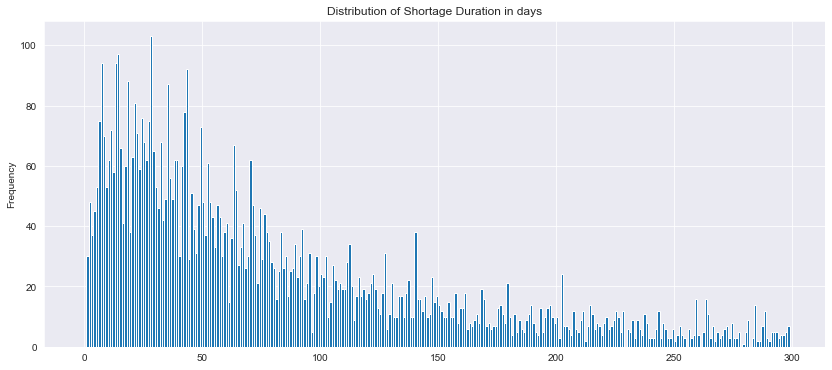

In [234]:
bin_values = np.arange(start=-2, stop=300, step=1)
(data['ShortageDuration'].astype('timedelta64[h]')/24).plot.hist(bins=bin_values,figsize=[14,6],title='Distribution of Shortage Duration in days')

In [227]:
(data['ShortageDuration'].astype('timedelta64[h]')/24).describe()

count    8321.000000
mean      222.651244
std       381.057773
min      -124.000000
25%        33.000000
50%        78.625000
75%       215.000000
max      5685.000000
Name: ShortageDuration, dtype: float64

In [244]:
data["ReportID"].duplicated().value_counts()

False    8321
Name: ReportID, dtype: int64

In [243]:
data["Company"].duplicated().value_counts()

True     8170
False     151
Name: Company, dtype: int64

In [267]:
diff = today - data.ActualEndDate[:2]
diff

0   280 days 17:36:07.166715
1   322 days 17:36:07.166715
Name: ActualEndDate, dtype: timedelta64[ns]

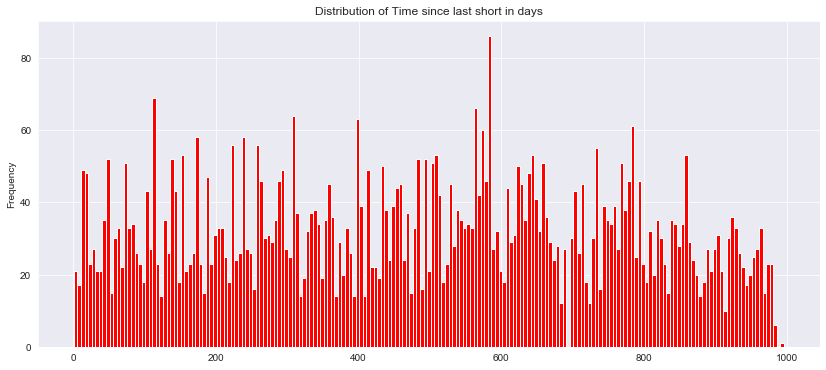

In [286]:
# Determine the time from the end of short
data['TimeFromEnd'] = today - data.ActualEndDate
bin_values = np.arange(start=1, stop=1000, step=5)
(data['TimeFromEnd'].astype('timedelta64[h]')/24).plot.hist(bins=bin_values,figsize=[14,6],color='r',title='Distribution of Time since last short in days')

In [27]:
data_no_discontinuation = (data['Shortage status'] != 'Discontinuation status')
data_no_avoided_shortage = (data['Shortage status'] != 'Avoided shortage')
data_no_anticipated_shortage = (data['Shortage status'] != 'Anticipated shortage')
data_mod = data[data_no_discontinuation] or data[data_no_avoided_shortage]
#data_mod = data[data_no_avoided_shortage]
#data_mod = data[data_no_anticipated_shortage]

ValueError: The truth value of a DataFrame is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

In [ ]:
data['days_short']= data['']

In [14]:
group_by_carrier = data.groupby(['Common or Proper name','Shortage status'])
#group_by_carrier.size()
count_delays_by_carrier = group_by_carrier.size().unstack()
count_delays_by_carrier
#count_delays_by_carrier.plot(kind='barh', stacked=True, figsize=[16,6], colormap='winter')

Shortage status,Actual shortage,Anticipated shortage,Avoided shortage,Discontinuation status,Resolved
Common or Proper name,,,,,
% 5 Dextrose Injection USP,NaN,NaN,NaN,NaN,1.0
%10 Dextrose Injection USP (500ml),NaN,NaN,NaN,NaN,1.0
(hepatitis B vaccine [recombinant]),4.0,NaN,NaN,NaN,2.0
"(measles, mumps and rubella virus vaccine, live, attenuated) Lyophilized powder for injection",NaN,NaN,NaN,NaN,4.0
(mirtazapine) Orally Disintegrating Tablets,NaN,NaN,1.0,NaN,4.0
...,...,...,...,...,...
viacoram,NaN,NaN,NaN,NaN,1.0
vorinostat capsules,NaN,NaN,NaN,NaN,1.0
warfarin,NaN,NaN,NaN,NaN,1.0
